# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.
also want to make this dynamic if in case some one want to use GPU


In [177]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
import torchvision.transforms as transforms
%matplotlib inline

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [178]:
class Env:
    """
    ENV class will be used as a dict for constant
    """
    batch_size = 20
    valid_size = 0.2
    num_workers = 0
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_on_gpu = torch.cuda.is_available()
    epochs = 20
    valid_loss_min = np.Inf
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [179]:
train_data = datasets.CIFAR10(root='', download=True, train=True, transform=Env.transform)
test_data = datasets.CIFAR10(root='', download=False, train=False, transform=Env.transform)

Files already downloaded and verified


In [180]:
#create train test and validation data loader.
indices = list(range(len(train_data)))
np.random.shuffle(indices)
split = int(np.floor(Env.valid_size * len(train_data)))
train_sampler = SubsetRandomSampler(indices[split:])
valid_sampler = SubsetRandomSampler(indices[:split])
train_loader = torch.utils.data.DataLoader(train_data,
                                           num_workers=Env.num_workers,
                                           sampler=train_sampler,
                                           batch_size=Env.batch_size)
valid_loader = torch.utils.data.DataLoader(train_data,
                                           num_workers=Env.num_workers,
                                           sampler=valid_sampler,
                                           batch_size=Env.batch_size)
test_loader = torch.utils.data.DataLoader(test_data,
                                           num_workers=Env.num_workers,
                                           batch_size=Env.batch_size)

/Users/omtripa/anaconda3/envs/deep-learning/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


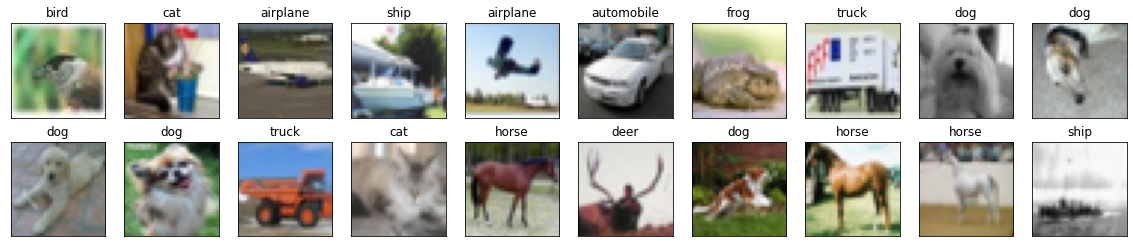

In [181]:
#visualize data
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(20,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(Env.classes[labels[idx]])

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

This time, you'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.

A network with 2 convolutional layers is shown in the image below and in the code, and you've been given starter code with one convolutional and one maxpooling layer.

<img src='notebook_ims/2_layer_conv.png' height=50% width=50% />

#### TODO: Define a model with multiple convolutional layers, and define the feedforward metwork behavior.

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting. 

It's good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) to help decide on a final structure.

#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [182]:
class NeuralNet(nn.Module):
    
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*4*4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = NeuralNet()
print(model)
if Env.train_on_gpu:
    model.cuda()

NeuralNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [183]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting. (In fact, in the below example, we could have stopped around epoch 33 or so!)

In [184]:
valid_loss_min = np.inf
for epoch in range(1, Env.epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for images, targets in train_loader:
        if Env.train_on_gpu:
            images, targets = images.cuda(), targets.cuda()
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, targets)
        loss.backward() 
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    
    model.eval()
    for images, targets in valid_loader:
        if Env.train_on_gpu:
            images, targets = images.cuda(), targets.cuda()
        output = model(images)
        loss = criterion(output, targets)
        valid_loss += loss.item() * images.size(0)
        
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(), 'cnn.pt')
        valid_loss_min = valid_loss
            

Epoch: 1 	Training Loss: 1.659103 	Validation Loss: 0.354439
Validation loss decreased (inf --> 0.354439).  Saving model ...
Epoch: 2 	Training Loss: 1.314390 	Validation Loss: 0.299035
Validation loss decreased (0.354439 --> 0.299035).  Saving model ...
Epoch: 3 	Training Loss: 1.177272 	Validation Loss: 0.277895
Validation loss decreased (0.299035 --> 0.277895).  Saving model ...
Epoch: 4 	Training Loss: 1.088361 	Validation Loss: 0.262649
Validation loss decreased (0.277895 --> 0.262649).  Saving model ...
Epoch: 5 	Training Loss: 1.013116 	Validation Loss: 0.232763
Validation loss decreased (0.262649 --> 0.232763).  Saving model ...
Epoch: 6 	Training Loss: 0.946089 	Validation Loss: 0.222951
Validation loss decreased (0.232763 --> 0.222951).  Saving model ...
Epoch: 7 	Training Loss: 0.891242 	Validation Loss: 0.210144
Validation loss decreased (0.222951 --> 0.210144).  Saving model ...
Epoch: 8 	Training Loss: 0.838674 	Validation Loss: 0.208252
Validation loss decreased (0.21014

###  Load the Model with the Lowest Validation Loss

In [215]:
model.load_state_dict(torch.load('cnn.pt'))

<All keys matched successfully>

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [216]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if Env.train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not Env.train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(Env.batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            Env.classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (Env.classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.760993

Test Accuracy of airplane: 82% (820/1000)
Test Accuracy of automobile: 87% (876/1000)
Test Accuracy of  bird: 64% (640/1000)
Test Accuracy of   cat: 58% (587/1000)
Test Accuracy of  deer: 68% (682/1000)
Test Accuracy of   dog: 68% (687/1000)
Test Accuracy of  frog: 77% (777/1000)
Test Accuracy of horse: 76% (766/1000)
Test Accuracy of  ship: 84% (843/1000)
Test Accuracy of truck: 74% (744/1000)

Test Accuracy (Overall): 74% (7422/10000)


/Users/omtripa/anaconda3/envs/deep-learning/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


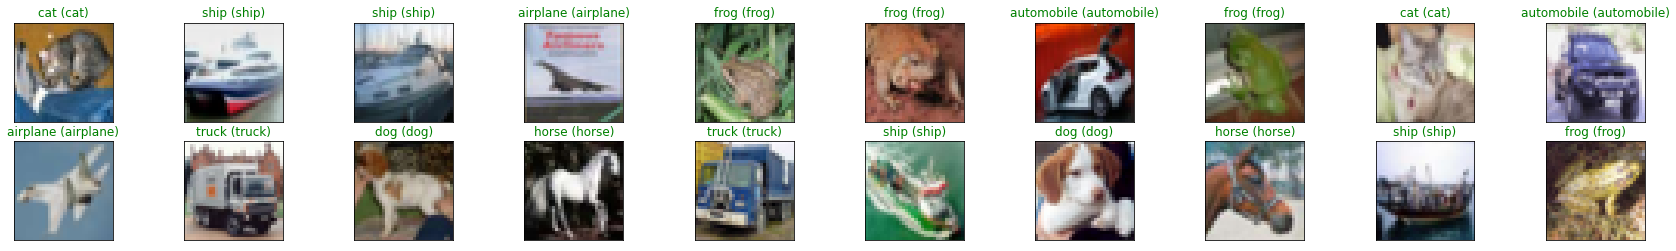

In [214]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if Env.train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not Env.train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(30, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(Env.classes[preds[idx]], Env.classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))